<a href="_index.ipynb">&larr; LTF-Index </a>&loz;
<a href="../../README.md"> &uarr; TOC &uarr; </a>
<img src='../_img/icon.svg' align='right' width='10%'></img>

# Zeitdiskrete Systeme im Frequenzbereich

In diesem Notebook wird gezeigt, wie man einfache zeitdiskrete Filter im Frequenzbereich charakterisieren kann, außerdem wird interaktiv demonstriert wie P/Z-Plan und Betragsgang zusammenhängen.

In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)
    
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.display import Image
from matplotlib import animation
from IPython.display import HTML
import numpy as np
from numpy import exp, cos, sin, pi
import scipy.signal as sig

import dsp_fpga_lib as dsp
dsp.versions()
plt.rcParams.update(dsp.mpl_rc) # define plot properties 

Python version: 3.8.17
Numpy: 1.24.4
Scipy: 1.10.1
Matplotlib: 3.7.2 module://matplotlib_inline.backend_inline


## Zwei LTI-Systeme (nochmal)

Die folgenden Bilder zeigen nochmal die Systeme aus dem vorigen Kapitel.

![LTI-MA.png](../_img/LTI-MA.png)


![LTI-kask_MA.png](../_img/LTI-kask_MA.png)

Sind die Betragsgänge beider Filter identisch? Wir werden das im Folgenden ausprobieren. 

Zusätzlich verwenden wir jetzt einen verlusbehafteten Akkumulator / Integrator:

![LTI-Damped_integrator.png](../_img/LTI-Damped_integrator.png)

Zunächst betrachten wir noch einmal das Verhalten des Systems im Zeitbereich:

## Definition des Filters über seine Koeffizienten
In der nächsten Zelle definieren wir das Filter über seine Koeffizienten; `b` enthält die Zähler-, `a` die Nennerkoeffizienten oder über Nullstellen `N`, Polstellen `P` und die Verstärkung `k`. Bei FIR-Filtern sind die Koeffizienten identisch zur Impulsantwort (warum?). Simulieren Sie die verschiedenen Systeme, versuchen Sie vorherzusagen wie P/N Diagramm und Betragsgang aussehen.

In [2]:
f_S = 500.0     # sampling frequency
b = np.ones(4); a = 1 # MA-filter, N = 5
#b = np.convolve([1,1,1],[1,1,1]); a = 1 
#b = [1, 0]; a = [1, +0.5] # lossy integrator
#b,a = sig.ellip(4, 0.2, 20, 0.25) # order, ripple passband, suppression stop band, corner frequency

Z,P,k = sig.tf2zpk(b,a)
k = 1
#Z = np.roots(b)
#P = np.roots(a)
Z = np.array([exp(1j * pi * 0.6), exp(-1j * pi * 0.6)])
#Z = 1/P # allpass

P = np.array([0.8* exp(1j * pi * 0.3), 0.8* exp(-1j * pi * 0.3)])
#P = np.array([-0.9])
#P = np.roots(a)
if len(P) < 1:
    P = np.zeros(len(Z))

print("Z =", Z)
print("P =", P)
print("k =", k)
b,a = sig.zpk2tf(Z,P,k)
print("b =", b)
print("a =", a)

Z = [-0.30901699+0.95105652j -0.30901699-0.95105652j]
P = [0.4702282+0.6472136j 0.4702282-0.6472136j]
k = 1
b = [1.         0.61803399 1.        ]
a = [ 1.        -0.9404564  0.64     ]


## Pol- und Nullstellendiagramm und Betragsgang
Zunächst stellen wir Impulsantwort, Pol-/Nullstellendiagramm und Betragsgang des Filters dar:

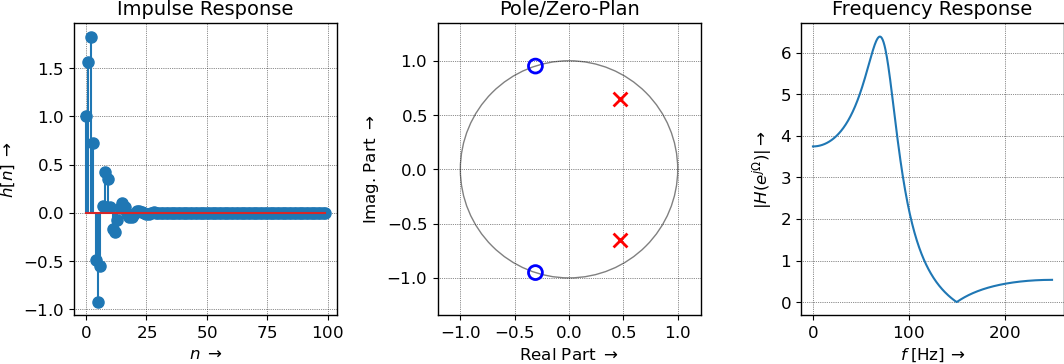

In [3]:
fig1, (ax11, ax12, ax13) = plt.subplots(1,3,figsize=(11,4))
h,n = dsp.impz(b,a)
ax11.stem(n,h)
ax11.set_xlabel(r'$n \; \rightarrow$'); ax11.set_ylabel(r'$h[n] \; \rightarrow$')
ax11.set_title('Impulse Response')
#
ax12.set_xlabel(r'Real Part $\rightarrow$'); ax12.set_ylabel(r'Imag. Part $\rightarrow$')
ax12.set_title('Pole/Zero-Plan')
dsp.zplane(b,a, plt_ax=ax12);
#
[W, H] = sig.freqz(b, a, whole=False) # kompl. Frequenzgang, ausgehend von b, a
[W, H] = sig.freqz_zpk(Z,P,k, whole=False) # # kompl. Frequenzgang, ausgehend von Z,P,K
f = W  / (2 * np.pi) * f_S
ax13.plot(f,abs(H))
ax13.set_ylabel(r'$|H(e^{j \Omega})| \rightarrow$')
ax13.set_xlabel(r'$f \; \mathrm{ [Hz]} \, \rightarrow$')
ax13.set_title('Frequency Response')
fig1.set_tight_layout(True);

Schließlich berechnen wir für `N` Datenpunkte den Betragsgang `mag`aus dem P/N-Diagramm, damit anschließend der animierte Plot geschmeidig abläuft

In [4]:
dpi = 100
fps = 30
N = 50 # number of frames / data points
# First set up the figure, the axis, and the plot element we want to animate
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
#ax1.set_autoscale_on(False); ax1.set(xlim=(-2, 2), ylim=(-2,2)); 
ax1.set_aspect('equal'); ax1.grid(True)
ax1.set_xlabel(r'Real Part $\rightarrow$'); ax1.set_ylabel(r'Imag. Part $\rightarrow$')
ax2.set(xlim=(0, f_S), ylim=(0, 4))
ax2.axvline(f_S/2, color='r', ls='--')
ax2.set_xlabel(r"$f \, [Hz] \;\rightarrow$")
ax2.set_ylabel(r"$|H \left( \mathrm{e}^{j 2 \pi F}\right) |\; \rightarrow$")
ax2.grid(True)

line_p, = ax1.plot([],[], 'r', lw = 0.5) # line(s) between poles and frequency point
line_z, = ax1.plot([],[], 'b', lw = 0.5) # line(s) between zeros and frequency point
point1, = ax1.plot([],[], 'o', ms = 10, mec = 'black',  mfc = 'yellow', alpha = 0.5)
text = ax1.text(-0.5,-0.5, "", ha = 'left', va = 'center') # text for line lengths
line2, = ax2.plot([],[], 'o', ms = 10, mec = 'black',  mfc = 'yellow', alpha = 0.5)

fig.set_tight_layout(True)

color_data = ['r', 'g', 'b']
scat = (0,0)

# Now pre-calculate coordinates along the unit circle and the distances 
F = np.linspace(0, 1, N)
f = F * f_S
x_uc = cos(2*pi*F)
y_uc = sin(2*pi*F)

pl = 1
zl = 1
mag = []
for n in range(len(P)):
    pl *= np.abs(x_uc + 1j*y_uc - P[n])
for n in range(len(Z)):
    zl *= np.abs(x_uc + 1j*y_uc - Z[n])

mag = k * zl / pl
print("{0} Datenpunkte berechnet!".format(len(mag)))

# initialization function: plot the background for all frames
# this function is called at the beginning of each animation cycle
def init():
    ax1.plot(x_uc, y_uc, "grey") # plot unit circle
    ax1.scatter(P.real, P.imag, marker = "x", color = 'red', s = 50) # plot poles
    ax1.scatter(Z.real, Z.imag, marker = "o", color = 'blue', s = 50) # plot zeros
    ax2.plot(np.abs(f), mag, 'k', lw = 2)
    ax2.set_ylim([min(mag),max(mag)])
    line_p.set_data([], []) # initialize data for lines 
    line_z.set_data([], [])
    point1.set_data([], [])
    line2.set_data([], [])
    
    text.set_text('')
    return line_p, line_z, point1, line2,

# This is the actual animation function: The first argument is an integer that
# is incremented with each interation, the other arguments are defined in the
# fargs kw of FuncAnimation
# Arguments passed back are animated
# 
def animate(i, color_data, scat):
    print(i,'.', end='', sep='') # suppress endline terminator and white space between numbers
    pl_x = []
    pl_y = []
    zl_x = []
    zl_y = []
    for n in range(len(P)):
        pl_x.append([x_uc[i], P[n].real])
        pl_y.append([y_uc[i], P[n].imag])
    for n in range(len(Z)):
        zl_x.append([x_uc[i], Z[n].real])
        zl_y.append([y_uc[i], Z[n].imag]) 
    line_p.set_data(pl_x, pl_y)
    line_z.set_data(zl_x, zl_y)

#    line2.set_data(F[:i], mag[:i])
    line2.set_data([f[i], mag[i]])
    point1.set_data([x_uc[i],y_uc[i]])
    text.set_text(
        str("ZL = %.2f" %(zl[i]) + "\n" + "PL = %.2f" %(pl[i]))  )
    return line_p, line_z, point1, line2, text

# Now call the animator:  
# blit=True: only re-draw the parts that have changed.
# frames: number of frames to be recorded
# interval: time between frames in ms = 1000/fps ; 
# total length = frames x interval
anim = animation.FuncAnimation(fig, animate, init_func=init, frames = N,
                               fargs=(color_data, scat))
plt.close() # close the additional static plot

50 Datenpunkte berechnet!


Für die Animation werden jetzt die `N` einzelnen Frames aufgebaut:

In [5]:
# Now run the animation
anim

0.

/tmp/ipykernel_64370/415016336.py:80: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line2.set_data([f[i], mag[i]])
/tmp/ipykernel_64370/415016336.py:81: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point1.set_data([x_uc[i],y_uc[i]])


1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.

### Aufgaben:
- Experimentieren Sie mit verschiedenen Systemen, die Sie in der zweiten Codezelle definieren.
- Vollziehen Sie den Zusammenhang nach zwischen P/N Positionen und Betragsgang der einzelnen Systeme

***
### Copyright

(c) 2016 - 2021 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp.

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use it for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing - Vorlesungsunterlagen mit Simulationsbeispielen, 2020*.